# 1. Loading im.db as pd.df

In [27]:
import pandas as pd
import sqlite3

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline


In [28]:
conn = sqlite3.connect('data/im.db')
cursor = conn.cursor()

In [29]:
imdb_basics = pd.read_sql('''
SELECT *
FROM movie_basics
''', conn)

imdb_akas = pd.read_sql('''
SELECT *
FROM movie_akas
WHERE region = 'US'
GROUP BY movie_id
''', conn)

imdb_ratings = pd.read_sql('''
SELECT *
FROM movie_ratings
''', conn)

# 2. Name of df Variables:

### imdb Variables (each variable is an individual table):
- imdb_basics
- imdb_akas
- imdb_ratings

# 3. Merging IMDB

In [30]:
akas_basics_merge = imdb_akas.merge(imdb_basics, on='movie_id',
                                        how='inner')
imdb_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [31]:
imdb_merged = akas_basics_merge.merge(imdb_ratings, on='movie_id',
                                       how='left')
imdb_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47433 entries, 0 to 47432
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           47433 non-null  object 
 1   ordering           47433 non-null  int64  
 2   title              47433 non-null  object 
 3   region             47433 non-null  object 
 4   language           325 non-null    object 
 5   types              4977 non-null   object 
 6   attributes         1652 non-null   object 
 7   is_original_title  47428 non-null  float64
 8   primary_title      47433 non-null  object 
 9   original_title     47432 non-null  object 
 10  start_year         47433 non-null  int64  
 11  runtime_minutes    39673 non-null  float64
 12  genres             46840 non-null  object 
 13  averagerating      26654 non-null  float64
 14  numvotes           26654 non-null  float64
dtypes: float64(4), int64(2), object(9)
memory usage: 5.8+ MB


# 4. Cleaning tn.movie_budgets for merge

In [32]:
tn_budgets = pd.read_csv('data/tn.movie_budgets.csv.gz')

In [33]:
tn_budgets.drop_duplicates(subset = ['movie'], inplace=True)

In [34]:
tn_budgets.rename(columns = {'movie':'primary_title'}, inplace=True)

In [35]:
#Creating new coumn called year that is date.time
tn_budgets['Release_Date_Time'] = pd.to_datetime(tn_budgets['release_date'])
tn_budgets['start_year'] = tn_budgets['Release_Date_Time'].dt.year
tn_budgets['month'] = tn_budgets['Release_Date_Time'].dt.month

# 5: MERGE Merging Budgets to IMDB

#### Also changing columns to match Anat and Keanan

In [36]:
imdb_merged.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0069049,2,The Other Side of the Wind,US,None,imdbDisplay,None,0.0,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0
1,tt0112502,1,Bigfoot,US,None,None,None,0.0,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller",4.1,32.0
2,tt0159369,3,Cooper and Hemingway: The True Gen,US,None,None,None,0.0,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,2013,180.0,Documentary,7.6,53.0
3,tt0192528,1,Heaven & Hell,US,None,imdbDisplay,None,0.0,Heaven & Hell,Reverse Heaven,2018,104.0,Drama,4.0,72.0
4,tt0230212,1,The Final Journey,US,None,None,None,0.0,The Final Journey,The Final Journey,2010,120.0,Drama,8.8,8.0


In [37]:
full_movies_df = imdb_merged.merge(tn_budgets, on= ['primary_title','start_year'], how= 'inner')

In [38]:
full_movies_df['worldwide_gross'] = full_movies_df['worldwide_gross'].str.replace('$','').str.replace(',','').astype(float)
full_movies_df['production_budget'] = full_movies_df['production_budget'].str.replace('$','').str.replace(',','').astype(float)
full_movies_df['domestic_gross'] = full_movies_df['domestic_gross'].str.replace('$','').str.replace(',','').astype(float)

# Analysis:
# Trends in Genre

In [39]:
#converting dataset to SQL to filter/drop columns easily
full_movies_sql = full_movies_df.to_sql('genres', conn, if_exists='replace', index = False)

In [40]:
#Using tables that are unique and useful
full_movies = pd.read_sql('''
SELECT movie_id, primary_title, genres, start_year, runtime_minutes,
        averagerating, numvotes, production_budget, worldwide_gross
FROM genres 
''', conn)

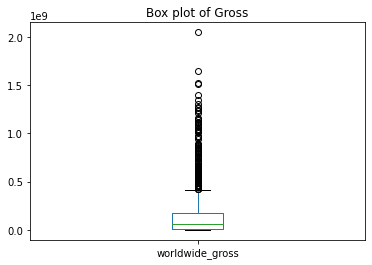

In [41]:
#boxplot of 'worldwide_gross' to find the best measure of central tendency
full_movies["worldwide_gross"].plot(kind="box", title="Box plot of Gross")
plt.show()

In [42]:
full_movies['genres'].value_counts()

Adventure,Animation,Comedy    65
Action,Adventure,Sci-Fi       52
Comedy                        51
Drama                         49
Comedy,Drama,Romance          49
                              ..
Sci-Fi,Thriller                1
Biography,Family,Sport         1
Adventure,Horror,Mystery       1
Drama,Thriller,Western         1
Musical                        1
Name: genres, Length: 217, dtype: int64

# Splitting genres column to isolate individual genres

In order to get a better picture of how genre effects worldwide gross I needed to isolate individual genres so that I could apply a central tendancy to the 'worldwide_gross' of
each genre and plot the results to show the average best performing genres.

The plot shows that Animation, Adventure, and Sci-FI are, on average, the highest performing
genres and will typically generate the highest revenue. This does not show the whole picture for genres. To understand the actual highest performing genres we have to look at the genres that
have combinations of these three genres.

So knowing what the top 3 performing genres are I filtered our data set to show the, full genres
(movies use multiple genres to define they're move) to show the top performing genres.


In [43]:
# spliting the genres column up so that each movie has an entry for each genre listed

genres = (full_movies.genres.str.split(',', expand=True)
            .stack()
            .to_frame(name='genres'))

genres.index = genres.index.droplevel(1)


In [44]:
# creating a new df by merging new columns back on the data set grouped by the median based off of box plot
genre_gross = (genres.join(full_movies.loc[:,['worldwide_gross']]).groupby('genres').median().sort_values('worldwide_gross', ascending=False))

In [45]:
#adding an index to new df because I don't know how to graph using the index as the x-axis
genre_gross_df = genre_gross.reset_index()

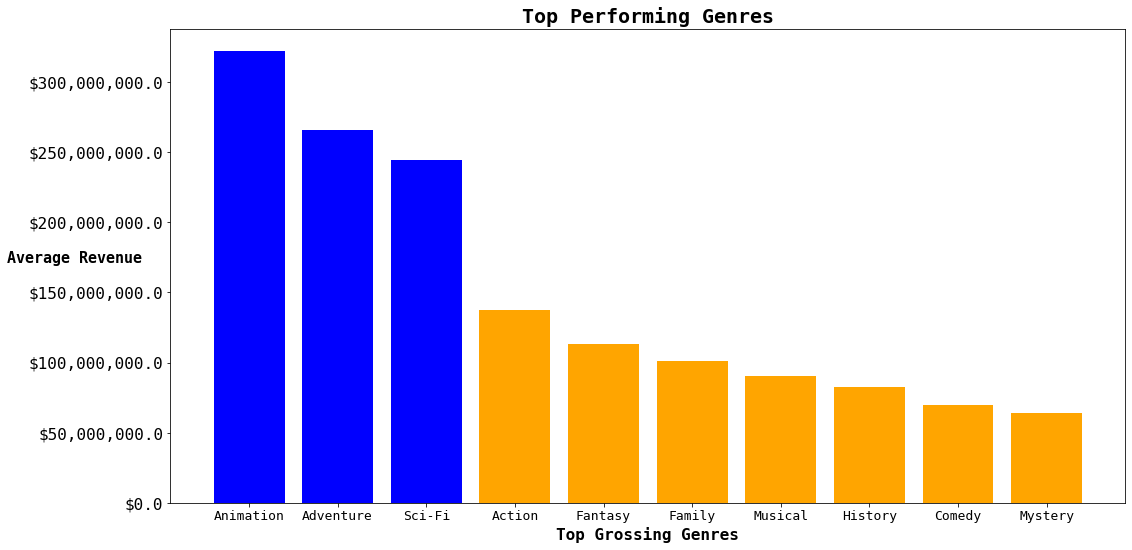

In [46]:


plt.rcParams['font.family'] = 'monospace'

x = genre_gross_df['genres'].head(10)
height= genre_gross_df['worldwide_gross'].head(10)
fig, ax = plt.subplots(figsize=(16,8))


color=['blue', 'blue', 'blue', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']
ax.bar(x=x, height=height, color=color)


plt.title("Top Performing Genres", fontsize=20, loc='center', weight='bold')
ax.set_xlabel('Top Grossing Genres', fontsize=16, weight='bold')

ax.set_ylabel('Average Revenue', fontsize=15, rotation=360, weight='bold', loc='center')
ax.ticklabel_format(style='plain', axis='y')

ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', labelsize=13)

ax.yaxis.set_label_coords(-0.1, 0.5)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))

plt.tight_layout(pad = 2.0)
plt.savefig('top_individual_genres.jpg', dpi=400)

In [47]:
top_genres = pd.read_sql('''
SELECT title, movie_id, production_budget, worldwide_gross, month, genres
FROM genres
WHERE genres LIKE '%Animation%' OR genres LIKE '%Adventure%' OR genres LIKE '%Sci-FI%'
ORDER BY worldwide_gross desc
''', conn)

In [48]:
top_10_full_genres = top_genres.groupby('genres')['worldwide_gross'].median().reset_index()
top_10_full_genres.columns = ['genres', 'median_gross']
top_10_full_genres.sort_values(by='median_gross', ascending=False, inplace=True)

In [49]:
top_10_full_genres.head(10)

,genres,median_gross
45,"Adventure,Fantasy",945577621.0
40,"Adventure,Drama,Sci-Fi",660825409.0
10,"Action,Adventure,Sci-Fi",560913841.0
1,"Action,Adventure,Animation",507064637.5
50,"Animation,Comedy,Family",469500298.0
47,"Adventure,Mystery,Sci-Fi",402448265.0
3,"Action,Adventure,Comedy",385851714.5
19,"Action,Sci-Fi",370541256.0
7,"Action,Adventure,Fantasy",349210715.0
18,"Action,Mystery,Sci-Fi",348319861.0


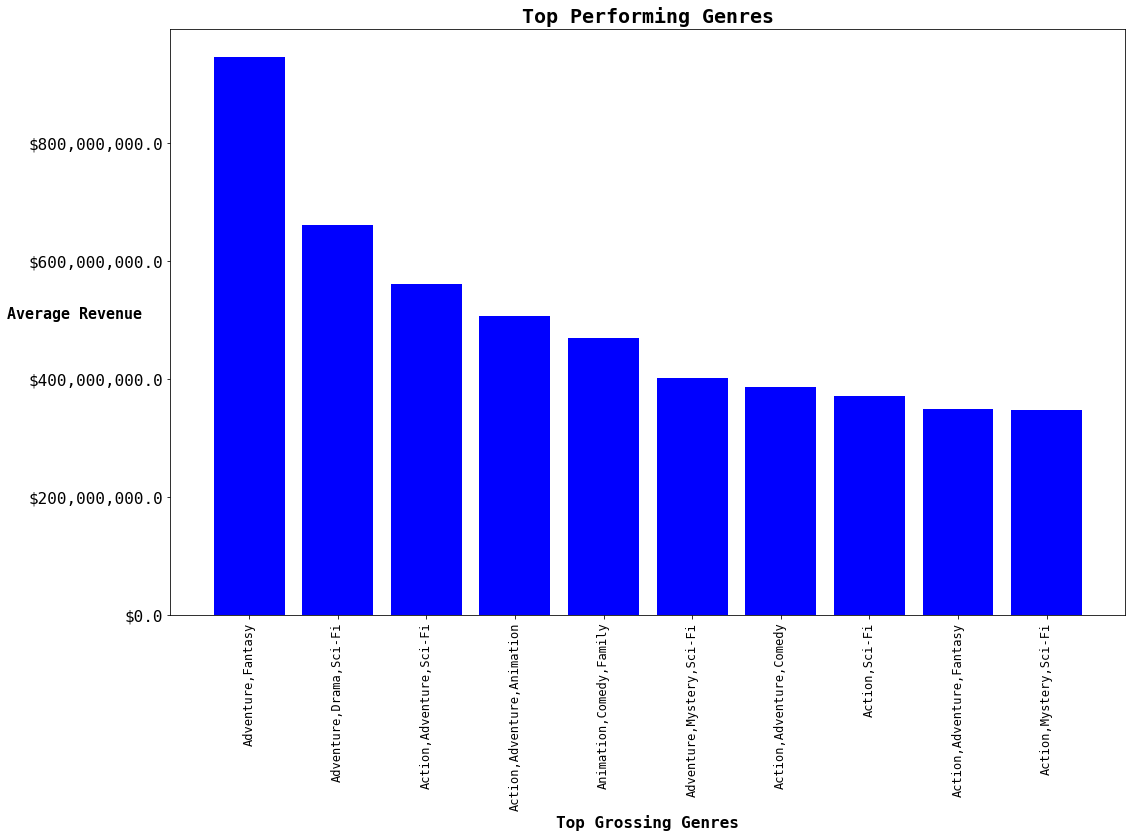

In [50]:
plt.rcParams['font.family'] = 'monospace'

x = top_10_full_genres['genres'].head(10)
height= top_10_full_genres['median_gross'].head(10)
fig, ax = plt.subplots(figsize=(16,12))



ax.bar(x=x, height=height, color='blue')


plt.title("Top Performing Genres", fontsize=20, loc='center', weight='bold')
ax.set_xlabel('Top Grossing Genres', fontsize=16, weight='bold')

ax.set_ylabel('Average Revenue', fontsize=15, rotation=360, weight='bold', loc='center')
ax.ticklabel_format(style='plain', axis='y')

ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', labelsize=12, rotation = 90)

ax.yaxis.set_label_coords(-0.1, 0.5)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))

plt.tight_layout(pad = 2.0)
plt.savefig('top_genres.jpg', dpi=400)














# Reccomendation Based on Our Combined Insights

In [51]:
full_movies_sql = full_movies_df.to_sql('genres', conn, if_exists='replace', index = False)

In [52]:
#### I can't get the month column to work correctly in the query. Not sure why

In [53]:
recomendation = pd.read_sql('''
SELECT title, movie_id, production_budget, worldwide_gross, month, genres
FROM genres
WHERE production_budget >= 65000000
                AND genres LIKE '%Adventure%' or genres LIKE '%Animation%' or genres LIKE '%Sci-FI%'
GROUP BY month, genres
ORDER BY worldwide_gross desc
''', conn)

In [54]:
recomendation

,title,movie_id,production_budget,worldwide_gross,month,genres
0,Jurassic World 3D,tt0369610,215000000.0,1.648855e+09,6,"Action,Adventure,Sci-Fi"
1,Ahab,tt1477834,160000000.0,1.146895e+09,12,"Action,Adventure,Fantasy"
2,Skyfall,tt1074638,200000000.0,1.110527e+09,11,"Action,Adventure,Thriller"
3,3,tt0435761,200000000.0,1.068880e+09,6,"Adventure,Animation,Comedy"
4,Alice in Wonderland: An IMAX 3D Experience,tt1014759,200000000.0,1.025491e+09,3,"Adventure,Family,Fantasy"
...,...,...,...,...,...,...
164,Rotor DR1,tt4162992,350000.0,0.000000e+00,10,"Family,Sci-Fi"
165,Independence Day-Saster,tt2645670,1800000.0,0.000000e+00,12,"Action,Adventure,Sci-Fi"
166,The Dead Undead,tt0923653,1100000.0,0.000000e+00,12,"Action,Horror,Sci-Fi"
167,Bird Box,tt2737304,19800000.0,0.000000e+00,12,"Drama,Horror,Sci-Fi"


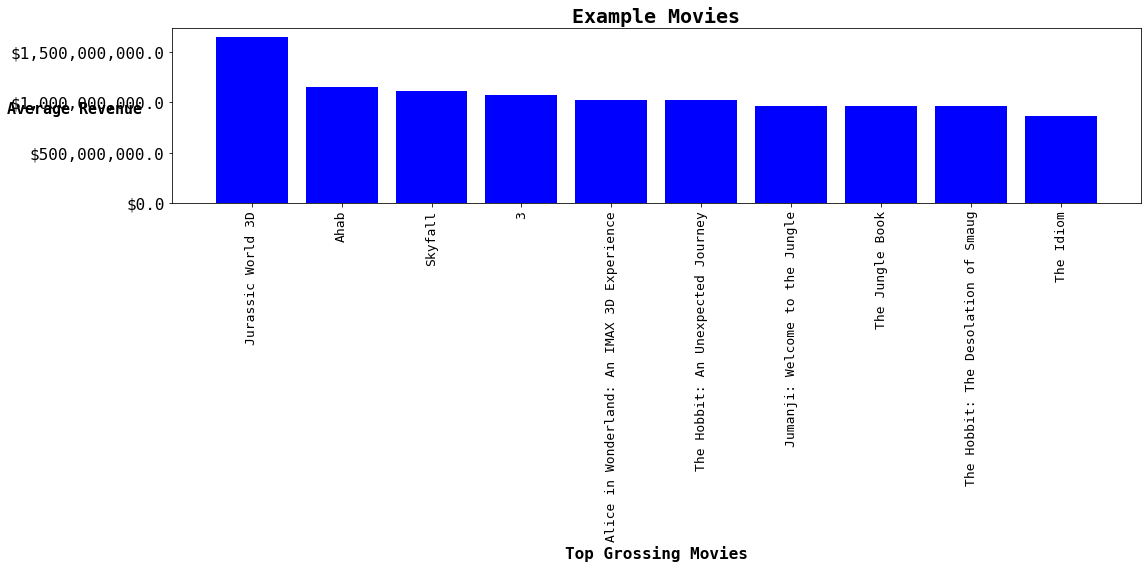

In [55]:
plt.rcParams['font.family'] = 'monospace'

x = recomendation['title'].head(10)
height= recomendation['worldwide_gross'].head(10)
fig, ax = plt.subplots(figsize=(16,8))



ax.bar(x=x, height=height, color= 'blue')


plt.title("Example Movies", fontsize=20, loc='center', weight='bold')
ax.set_xlabel('Top Grossing Movies', fontsize=16, weight='bold')

ax.set_ylabel('Average Revenue', fontsize=15, rotation=360, weight='bold', loc='center')
ax.ticklabel_format(style='plain', axis='y')

ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', labelsize=13, rotation = 90)

ax.yaxis.set_label_coords(-0.1, 0.5)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))

plt.tight_layout()
plt.savefig('example_reccomendations.jpg', dpi=400)

In [56]:
recomendation.head(10)

,title,movie_id,production_budget,worldwide_gross,month,genres
0,Jurassic World 3D,tt0369610,215000000.0,1.648855e+09,6,"Action,Adventure,Sci-Fi"
1,Ahab,tt1477834,160000000.0,1.146895e+09,12,"Action,Adventure,Fantasy"
2,Skyfall,tt1074638,200000000.0,1.110527e+09,11,"Action,Adventure,Thriller"
3,3,tt0435761,200000000.0,1.068880e+09,6,"Adventure,Animation,Comedy"
4,Alice in Wonderland: An IMAX 3D Experience,tt1014759,200000000.0,1.025491e+09,3,"Adventure,Family,Fantasy"
5,The Hobbit: An Unexpected Journey,tt0903624,250000000.0,1.017004e+09,12,"Adventure,Family,Fantasy"
6,Jumanji: Welcome to the Jungle,tt2283362,90000000.0,9.644962e+08,12,"Action,Adventure,Comedy"
7,The Jungle Book,tt3040964,175000000.0,9.628545e+08,4,"Adventure,Drama,Family"
8,The Hobbit: The Desolation of Smaug,tt1170358,250000000.0,9.603669e+08,12,"Adventure,Fantasy"
9,The Idiom,tt1951264,130000000.0,8.648680e+08,11,"Action,Adventure,Sci-Fi"
